In [129]:
import re
import random
import pandas as pd
import hashlib

In [130]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.5) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [131]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Python,326.704395,6.951157,15.543926,47
Powershell,505.516999,101.103400,246.568036,5
Todd Ideas,938.202097,62.546806,152.474358,15
PEP 8,1417.071484,177.133936,586.815705,8
SharePoint,1654.000112,137.833343,577.992781,12
Audit Report Tracker (Sharepoint List),1781.739402,137.056877,365.468020,13
Debugging in VS Code,1923.156332,96.157817,260.488600,20
Azure Functions + Visual Studio,1941.429600,138.673543,481.555817,14
Terraform,2050.518761,82.020750,252.501644,25
IW Migration,2117.530048,151.252146,459.560468,14


# Histogram

82109.00


<Axes: >

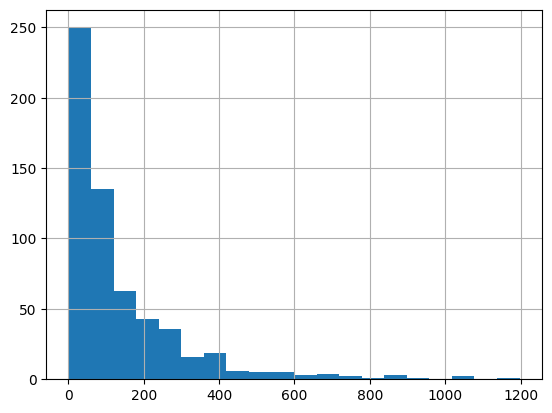

In [132]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [133]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [134]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [135]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [136]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [137]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [138]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [139]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [140]:
# n=10
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [141]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Age Max

In [142]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [143]:
n=10
existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'frequency', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)



Cards found: 595


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold
0,Powershell,error during connect\nIndicates the Docker CLI...,fa14e849210808f8bf87d29005622d6d,-246.568036,-101.103400,246.568036,505.516999,0.795616,5,0,0
1,Powershell,NUL\nA virtual file in Windows that discards w...,eb95bc3e9d7175749fa85f045565d15f,-119.129476,-101.103400,246.568036,505.516999,0.795616,5,1,0
2,Powershell,Get-Service\nDisplays the status of Windows se...,61dbfe3e3fd4becf9c271f621539b52a,-83.724590,-101.103400,246.568036,505.516999,0.795616,5,2,0
3,Powershell,-Force\nOverrides warnings or confirmation pro...,6d7a53df80e0774571798b7e4c583afe,-31.825169,-101.103400,246.568036,505.516999,0.795616,5,3,0
4,Powershell,az\nThe Azure CLI command-line tool for managi...,9376de9d5b22a60393b68271da0c480e,-24.269728,-101.103400,246.568036,505.516999,0.795616,5,4,0
5,PEP 8,Use Parentheses for Multi-Line Imports: When i...,b2d69c860e3a1150436c552d740b2aa6,-586.815705,-177.133936,586.815705,1417.071484,0.482654,8,0,0
6,PEP 8,One Import Per Line: Place each import stateme...,510a6ed6e688465b274d1e07eb0ae246,-210.632088,-177.133936,586.815705,1417.071484,0.482654,8,1,0
7,PEP 8,Prevent Circular Imports: Avoid scenarios wher...,83d6663484104f7621d02d4be77e3d89,-139.553285,-177.133936,586.815705,1417.071484,0.482654,8,2,0
9,PEP 8,Prefer Absolute Imports: Use full paths for im...,03079d188b068f5ee4f7d0ee2596bb63,-115.801919,-177.133936,586.815705,1417.071484,0.482654,8,3,0
8,PEP 8,Spaces Around Assignment Operators: Use spaces...,8f3054071b8a4967c311ba46c8feea17,-114.879491,-177.133936,586.815705,1417.071484,0.482654,8,4,0



## Random

In [144]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [145]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold
0,Powershell,error during connect\nIndicates the Docker CLI...,fa14e849210808f8bf87d29005622d6d,-246.568036,-101.103400,246.568036,505.516999,0.795616,5,0,0
1,Powershell,NUL\nA virtual file in Windows that discards w...,eb95bc3e9d7175749fa85f045565d15f,-119.129476,-101.103400,246.568036,505.516999,0.795616,5,1,0
2,Powershell,Get-Service\nDisplays the status of Windows se...,61dbfe3e3fd4becf9c271f621539b52a,-83.724590,-101.103400,246.568036,505.516999,0.795616,5,2,0
3,Powershell,-Force\nOverrides warnings or confirmation pro...,6d7a53df80e0774571798b7e4c583afe,-31.825169,-101.103400,246.568036,505.516999,0.795616,5,3,0
4,Powershell,az\nThe Azure CLI command-line tool for managi...,9376de9d5b22a60393b68271da0c480e,-24.269728,-101.103400,246.568036,505.516999,0.795616,5,4,0
5,PEP 8,Use Parentheses for Multi-Line Imports: When i...,b2d69c860e3a1150436c552d740b2aa6,-586.815705,-177.133936,586.815705,1417.071484,0.482654,8,0,0
6,PEP 8,One Import Per Line: Place each import stateme...,510a6ed6e688465b274d1e07eb0ae246,-210.632088,-177.133936,586.815705,1417.071484,0.482654,8,1,0
7,PEP 8,Prevent Circular Imports: Avoid scenarios wher...,83d6663484104f7621d02d4be77e3d89,-139.553285,-177.133936,586.815705,1417.071484,0.482654,8,2,0
9,PEP 8,Prefer Absolute Imports: Use full paths for im...,03079d188b068f5ee4f7d0ee2596bb63,-115.801919,-177.133936,586.815705,1417.071484,0.482654,8,3,0
8,PEP 8,Spaces Around Assignment Operators: Use spaces...,8f3054071b8a4967c311ba46c8feea17,-114.879491,-177.133936,586.815705,1417.071484,0.482654,8,4,0


In [146]:
existing_cards['age'].mean()

-137.9983117981695